In [2]:
# Importations de packages
import numpy as np
import geopandas as gpd
import folium
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from shapely import Point
import seaborn as sns 

pd.options.display.max_columns = 999

In [3]:
from src.config import *
from src.utils import make_path, check_dir
from src.traitements import AppariementRunner
from src.traitements import get_communes_from_radius

### Utils

In [6]:
# stats ze

nums_cols = ['area',
       'number_mun', 'population_t0', 'density_pop_km2_t0', 'number_ware_t0',
       'number_ware_per_popM_t0', 'number_ware_per_1000km2_t0',
       'avg_size_ware_t0', 'gravity_t0', 'population_t1', 'density_pop_km2_t1',
       'number_ware_t1', 'number_ware_per_popM_t1',
       'number_ware_per_1000km2_t1', 'avg_size_ware_t1', 'gravity_t1',
       'pop_change', 'gravity_change', 'number_ware_change',
       'perc_ware_change', 'number_ware_per_popM_change', 'log_sprawl_measure'] 

def load_measure(roi_name, period=(2008, 2023)): 
    period_str = '_'.join(list(map(str, period)))
    out_dir = check_dir(project_path, "reports", roi_name)
    fpath = [make_path(f, out_dir) for f in os.listdir(out_dir) if period_str in f][0] 
    gdf = gpd.read_file(fpath)
    for c in nums_cols: 
        gdf[c] = gdf[c].astype(float)

    return gdf

In [7]:
def make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=None): 
    
    columns = columns if columns is not None else list(wh_t0.columns)

    df = pd.concat(
    [
        wh_t0[columns].rename({_:f"{_}_t0" for _ in columns}, axis=1), 
        wh_t1[columns].rename({_:f"{_}_t1" for _ in columns}, axis=1), 
        wh_t2[columns].rename({_:f"{_}_t2" for _ in columns}, axis=1)
    ], axis=1)

    return df

## LYON

### Evolution of wh Dist to centroid

In [8]:
roi_name = "lyon"

year_t0 = "2008"
year_t1 = "2013"
year_t2 = "2023"

s_buffer = 25

out_dir = check_dir(project_path, "reports", roi_name)
wh_app_path = make_path("Appariement", processed_data_path, roi_name, "{}") #roi_name, year, buffer_size

_fname = "Entrepots_{}_{}_{}km_app.gpkg" #roi_name, year, buffer_size
wh_app_path_t0 = make_path(_fname.format(roi_name.upper(), year_t0, s_buffer), wh_app_path.format(year_t0))
wh_app_path_t1 = make_path(_fname.format(roi_name.upper(), year_t1, s_buffer), wh_app_path.format(year_t1))
wh_app_path_t2 = make_path(_fname.format(roi_name.upper(), year_t2, s_buffer), wh_app_path.format(year_t2))

wh_t0 = gpd.read_file(wh_app_path_t0)
wh_t1 = gpd.read_file(wh_app_path_t1)
wh_t2 = gpd.read_file(wh_app_path_t2)

/tmp/ipykernel_271176/211855443.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
/tmp/ipykernel_271176/211855443.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
/tmp/

2008 : 6.753907996874046
2013 : 7.892539531912643
2023 : 10.544946026789257


Text(0.5, 0.98, 'Evolution des distances des entrepôts au barycentre logistique')

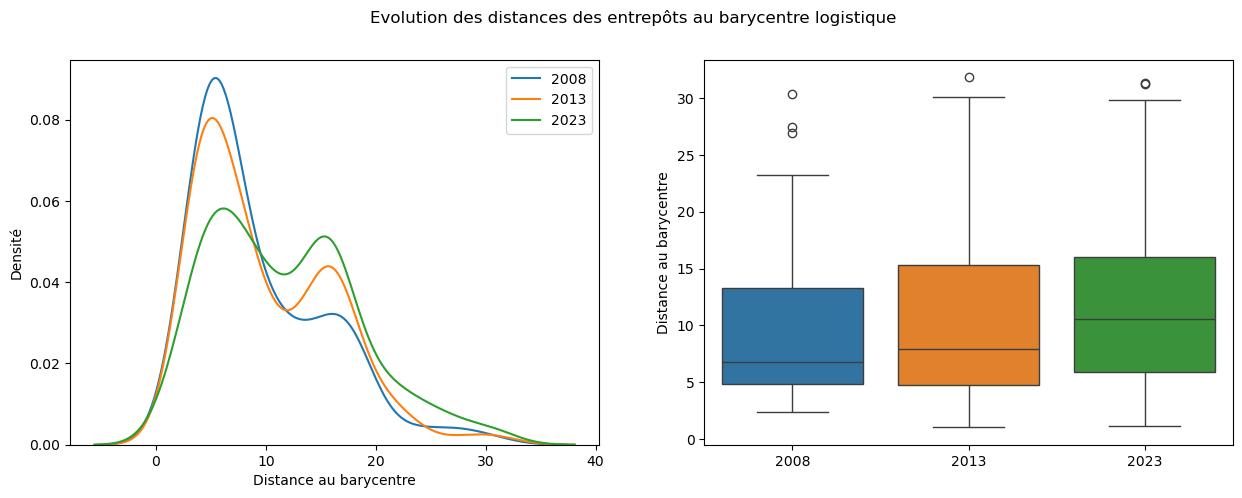

In [9]:
def get_dist_centroid(wh_df): 
    wh_centroid = np.mean(wh_df.centroid.x), np.mean(wh_df.centroid.y)
    return wh_df.distance(Point(wh_centroid)) / 1000

wh_t0["dist_centroid"] = get_dist_centroid(wh_t0)
wh_t1["dist_centroid"] = get_dist_centroid(wh_t1)
wh_t2["dist_centroid"] = get_dist_centroid(wh_t2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

col = "dist_centroid"
median_t0 = np.median(wh_t0[col])
median_t1 = np.median(wh_t1[col])
median_t2 = np.median(wh_t2[col])

print(f"{year_t0} : {median_t0}")
print(f"{year_t1} : {median_t1}")
print(f"{year_t2} : {median_t2}")


sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
sns.distplot(wh_t2[col], ax=axes[0], label=year_t2,  hist=False)

axes[0].set_xlabel("Distance au barycentre")
axes[0].set_ylabel("Densité")
axes[0].legend()


df_dist = pd.concat(
    [
        wh_t0["dist_centroid"].rename(f"{year_t0}"), 
        wh_t1["dist_centroid"].rename(f"{year_t1}"), 
        wh_t2["dist_centroid"].rename(f"{year_t2}")
    ], axis=1)


sns.boxplot(df_dist, ax=axes[1])
axes[1].set_ylabel("Distance au barycentre")

fig.suptitle('Evolution des distances des entrepôts au barycentre logistique', fontsize=12)

/tmp/ipykernel_271176/1269739511.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([year_t0, year_t1, year_t2])


Text(0.5, 1.0, "Evolution du nombre d'entrepôts 2008-2023")

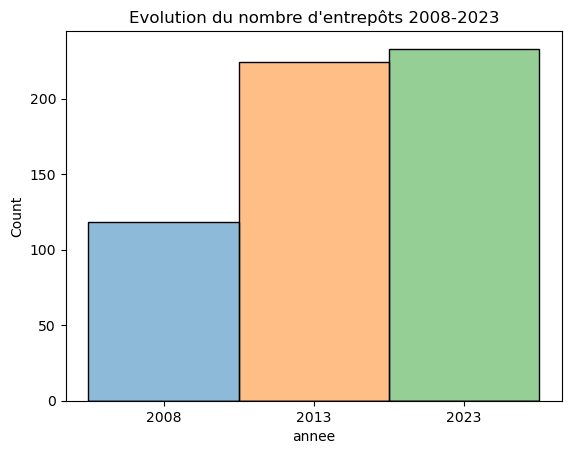

In [12]:
df_hist = make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=["ID"])
cnt = df_hist[["ID_t0","ID_t1", "ID_t2"]].melt(var_name="annee").dropna()
sns.histplot(x=cnt.annee, hue=cnt.annee, legend=False)
#plt.xticks_(plt.xticks(), labels=[year_t0, year_t1, year_t2])
ax = plt.gca()
ax.set_xticklabels([year_t0, year_t1, year_t2])
plt.title("Evolution du nombre d'entrepôts 2008-2023")

In [11]:
wh_t0.columns

Index(['ID', 'NATURE', 'geometry', 'dist_centroid'], dtype='object')

## Bordeaux

In [13]:
roi_name = "bordeaux"

year_t0 = "2008"
year_t1 = "2013"
year_t2 = "2023"

s_buffer = 25

out_dir = check_dir(project_path, "reports", roi_name)
wh_app_path = make_path("Appariement", processed_data_path, roi_name, "{}") #roi_name, year, buffer_size


_fname = "Entrepots_{}_{}_{}km_app.gpkg" #roi_name, year, buffer_size
wh_app_path_t0 = make_path(_fname.format(roi_name.upper(), year_t0, s_buffer), wh_app_path.format(year_t0))
wh_app_path_t1 = make_path(_fname.format(roi_name.upper(), year_t1, s_buffer), wh_app_path.format(year_t1))
wh_app_path_t2 = make_path(_fname.format(roi_name.upper(), year_t2, s_buffer), wh_app_path.format(year_t2))

wh_t0 = gpd.read_file(wh_app_path_t0)
wh_t1 = gpd.read_file(wh_app_path_t1)
wh_t2 = gpd.read_file(wh_app_path_t2)

/tmp/ipykernel_271176/211855443.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
/tmp/ipykernel_271176/211855443.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
/tmp/

2008 : 6.111803954649487
2013 : 6.685112878589824
2023 : 7.1505584327142575


Text(0.5, 0.98, 'Evolution des distances des entrepôts au barycentre logistique')

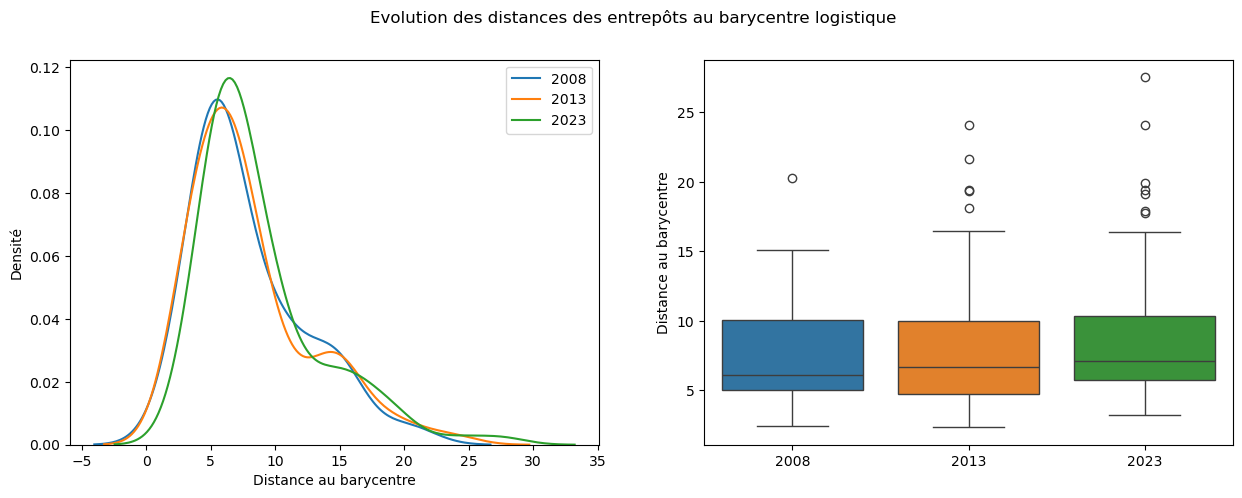

In [14]:
def get_dist_centroid(wh_df): 
    wh_centroid = np.mean(wh_df.centroid.x), np.mean(wh_df.centroid.y)
    return wh_df.distance(Point(wh_centroid)) / 1000

wh_t0["dist_centroid"] = get_dist_centroid(wh_t0)
wh_t1["dist_centroid"] = get_dist_centroid(wh_t1)
wh_t2["dist_centroid"] = get_dist_centroid(wh_t2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

col = "dist_centroid"
median_t0 = np.median(wh_t0[col])
median_t1 = np.median(wh_t1[col])
median_t2 = np.median(wh_t2[col])

print(f"{year_t0} : {median_t0}")
print(f"{year_t1} : {median_t1}")
print(f"{year_t2} : {median_t2}")


sns.distplot(wh_t0[col], ax=axes[0], label=year_t0, hist=False)
sns.distplot(wh_t1[col], ax=axes[0], label=year_t1,  hist=False)
sns.distplot(wh_t2[col], ax=axes[0], label=year_t2,  hist=False)

axes[0].set_xlabel("Distance au barycentre")
axes[0].set_ylabel("Densité")
axes[0].legend()


df_dist = pd.concat(
    [
        wh_t0["dist_centroid"].rename(f"{year_t0}"), 
        wh_t1["dist_centroid"].rename(f"{year_t1}"), 
        wh_t2["dist_centroid"].rename(f"{year_t2}")
    ], axis=1)


sns.boxplot(df_dist, ax=axes[1])
axes[1].set_ylabel("Distance au barycentre")

fig.suptitle('Evolution des distances des entrepôts au barycentre logistique', fontsize=12)

/tmp/ipykernel_271176/769470566.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([year_t0, year_t1, year_t2])


Text(0.5, 1.0, "Evolution du nombre d'entrepôts 2008-2023")

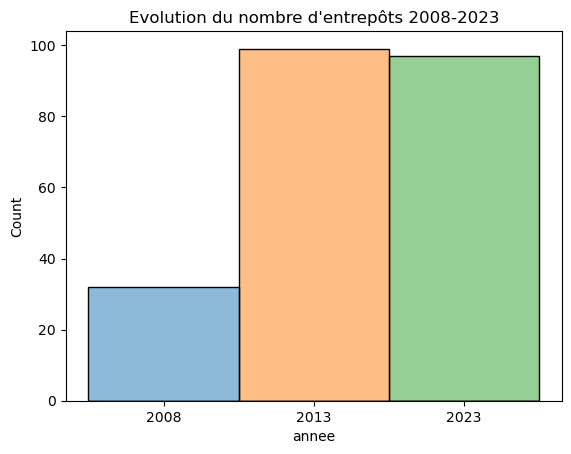

In [15]:
df_hist = make_concat_ds_year(wh_t0, wh_t1, wh_t2, columns=["ID"])

cnt = df_hist[["ID_t0","ID_t1", "ID_t2"]].melt(var_name="annee").dropna()
sns.histplot(x=cnt.annee, hue=cnt.annee, legend=False)
#plt.xticks_(plt.xticks(), labels=[year_t0, year_t1, year_t2])
ax = plt.gca()
ax.set_xticklabels([year_t0, year_t1, year_t2])
plt.title("Evolution du nombre d'entrepôts 2008-2023")

2024-03-13 08:02:07,490 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-13 08:02:07,495 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'logistic sprawl w.r.t study area radius - (2008, 2023)')

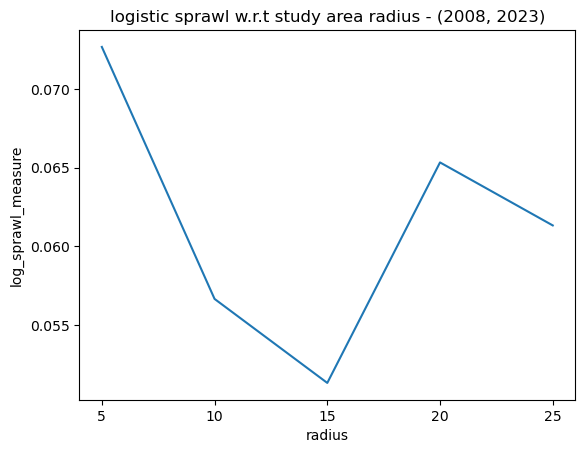

In [16]:
period = (2008, 2023)
df = load_measure(roi_name, period=period)

sns.lineplot(x=df.radius, y=df.log_sprawl_measure)
plt.title(f"logistic sprawl w.r.t study area radius - {period}")

## Annexes

In [221]:
df

,radius,metro,mega_region,country,continent,data_sources,time_period_start,time_period_end,years_data,surfaces_area_available,urban_centrality,gateway,area,number_mun,population_t0,density_pop_km2_t0,number_ware_t0,number_ware_per_popM_t0,number_ware_per_1000km2_t0,avg_size_ware_t0,gravity_t0,population_t1,density_pop_km2_t1,number_ware_t1,number_ware_per_popM_t1,number_ware_per_1000km2_t1,avg_size_ware_t1,gravity_t1,pop_change,gravity_change,number_ware_change,perc_ware_change,number_ware_per_popM_change,log_sprawl_measure,geometry
0,5,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,166.0,14,0.82,4929.9,33,40.0,0.0001988668036324916,5294.38,3.47,1.16,6975.17,29,25.0,0.00017473411150777576,3598.66,4.62,0.33999999999999997,1.15,-4,-12.121212121212121,-15.0,0.07666666666666666,None
1,10,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,507.6,50,1.23,2437.05,79,64.0,0.00015648117338853756,5298.68,6.03,1.7,3352.14,100,59.0,0.00019700745529619513,4396.42,6.61,0.47,0.5800000000000001,21,26.582278481012654,-5.0,0.03866666666666667,None
2,15,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,939.4,94,1.46,1558.64,95,65.0,0.00010112269154440266,5598.12,7.05,2.11,2245.59,144,68.0,0.0001532837547820094,5439.66,8.11,0.6499999999999999,1.0599999999999996,49,51.578947368421055,3.0,0.07066666666666664,None
3,20,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,1664.6,148,1.69,1036.56,101,60.0,6.200333132561778e-05,5701.53,7.52,2.48,1491.0,173,70.0,0.00010392868625654931,6490.78,9.83,0.79,2.3100000000000005,72,71.28712871287128,10.0,0.15400000000000003,None
4,25,lyon,,France,Europe,"BDTOPO_IGN,SIREN",2008,2023,15,True,,,2386.7,216,1.91,802.14,118,62.0,4.9440055431413705e-05,6376.98,9.41,2.82,1181.97,233,83.0,9.762407825448895e-05,8925.48,11.75,0.9099999999999999,2.34,115,97.45762711864407,21.0,0.156,None


In [239]:
columns = ["radius"] + ["pop_change", "gravity_change", "number_ware_change", "number_ware_per_popM_change", "log_sprawl_measure"]
df[columns].dtypes

radius                         object
pop_change                     object
gravity_change                 object
number_ware_change             object
number_ware_per_popM_change    object
log_sprawl_measure             object
dtype: object

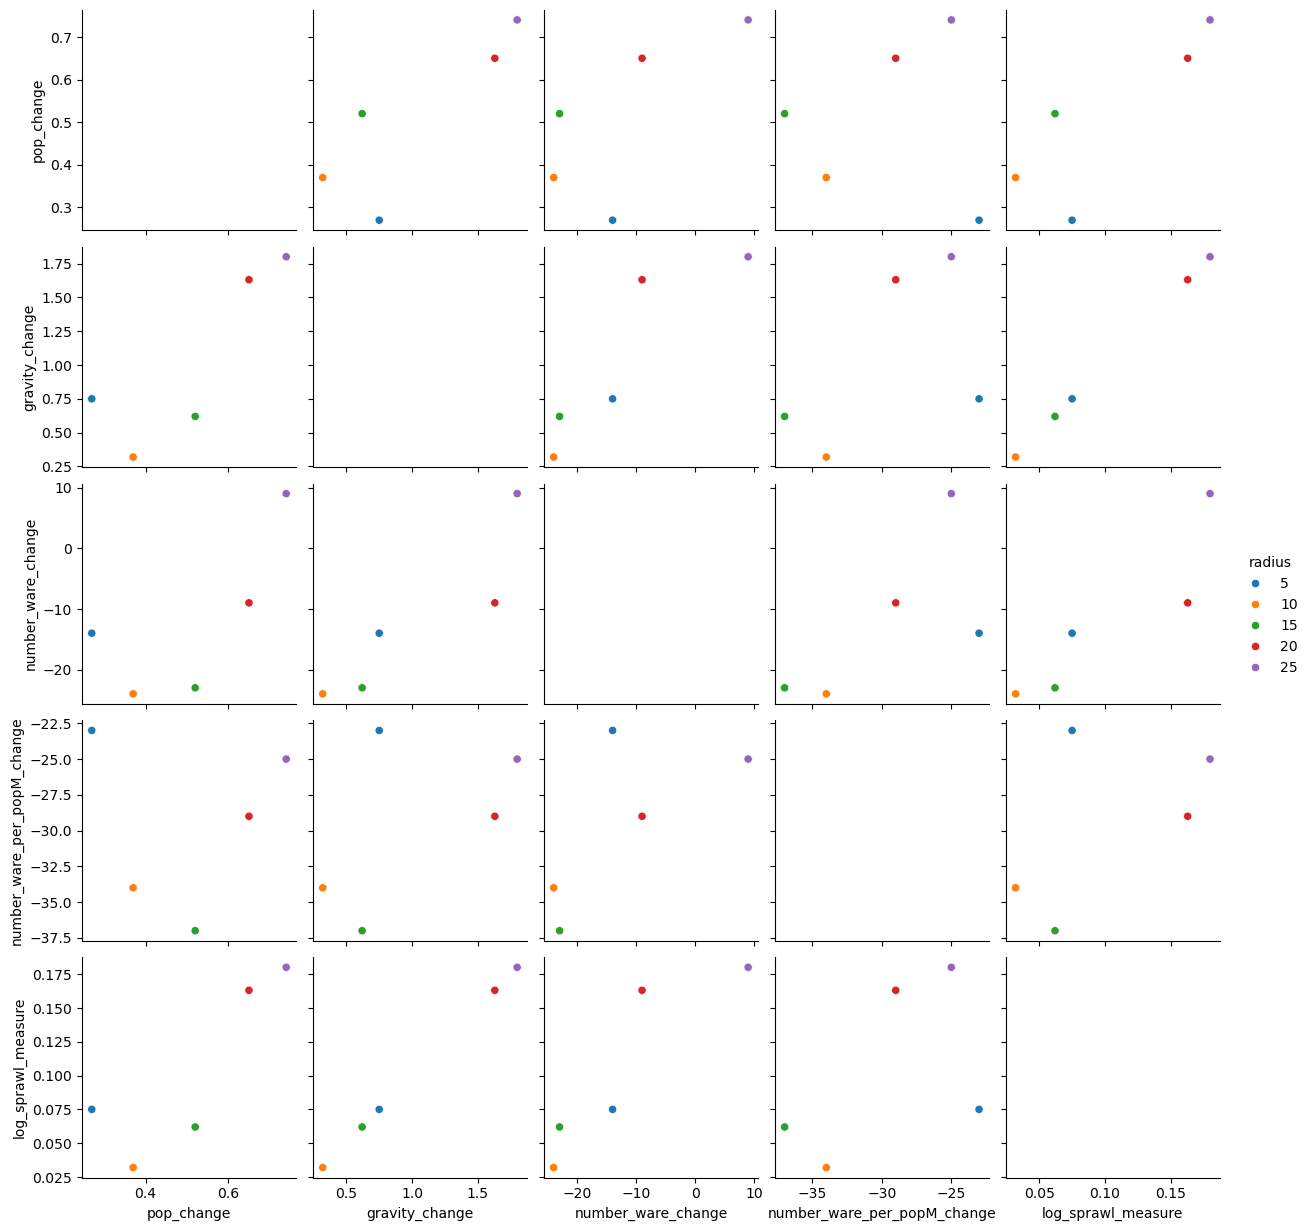

In [246]:
columns = ["radius"] + ["pop_change", "gravity_change", "number_ware_change", "number_ware_per_popM_change", "log_sprawl_measure"]
sns.pairplot(df[columns], hue="radius")

2024-03-11 15:24:06,549 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,551 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,553 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-03-11 15:24:06,553 - INFO ::  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<BarContainer object of 5 artists>

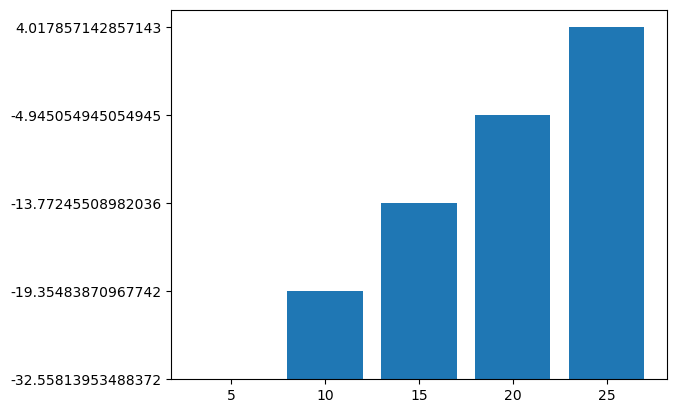

In [233]:
plt.bar(df.radius, df.perc_ware_change)

In [234]:
df.perc_ware_change

0    -32.55813953488372
1    -19.35483870967742
2    -13.77245508982036
3    -4.945054945054945
4     4.017857142857143
Name: perc_ware_change, dtype: object